In [1]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 6.0 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
import random
import requests
import pandas as pd
from pathlib import Path
import numpy as np
import os
import py7zr
from tqdm.auto import tqdm

In [3]:
# set device by checking if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

In [5]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# root directory for data
root_dir = 'drive/MyDrive/Colab Notebooks/Deep Learning Fundamentals/Assignment 2/cifar-10/'

Mounted at /content/drive


**DATA PREPROCESSING**

In [6]:
with py7zr.SevenZipFile(root_dir + 'train.7z', mode='r') as archive:
    archive.extractall(path='./')

# with py7zr.SevenZipFile(root_dir + 'test.7z', mode='r') as archive:
#     archive.extractall(path='./')

In [7]:
df = pd.read_csv(root_dir + 'trainLabels.csv')
df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [8]:
labels = dict()

for _,row in df.iterrows():
    labels[row['id']] = row['label']

In [9]:
class CIFAR10(Dataset):
    def __init__(self, image_folder, labels, transform=None):
        """
        Args:
            image_folder (str): Path to the folder containing images.
            labels (list): List of labels corresponding to each image.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_folder = image_folder
        self.transform = transform
        self.image_filenames = os.listdir(image_folder)  # List all image files in the folder
        self.labels = labels
        self.classes = sorted(list(set(labels.values())))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        # Load image
        img_name = os.path.join(self.image_folder, self.image_filenames[idx])
        image = Image.open(img_name).convert("RGB")  # Convert image to RGB mode

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        img_id = int(self.image_filenames[idx].split('.')[0])
        img_class = self.labels[img_id]
        label = self.classes.index(img_class)

        return image, label

In [10]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), # resize the image
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # apply data augmentation
    transforms.ToTensor(), # convert the image into a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
train_data = CIFAR10('train/', labels, train_transform)

In [12]:
print(train_data.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [13]:
print(len(train_data))

50000


In [14]:
image,label = train_data[200]
print(image.shape)
print(label)

torch.Size([3, 224, 224])
8


Text(0.5, 1.0, 'ship')

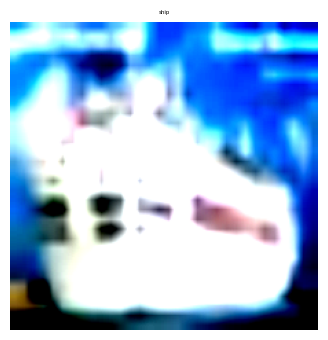

In [15]:
# rearrange the image dimensions
image_permute = image.permute(1,2,0)

# display the image
plt.figure(figsize=(6,4))
plt.imshow(image_permute)
plt.axis("off")
plt.title(train_data.classes[label], fontsize=4)

In [16]:
BATCH_SIZE = 32

# convert dataset to dataloader
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

# test_dataloader = DataLoader(test_data,
#                              batch_size=BATCH_SIZE,
#                              num_workers=os.cpu_count(),
#                              shuffle=False)

In [17]:
# get a batch of images and labels from the dataloader
train_images,train_labels = next(iter(train_dataloader))
print(train_images.shape)
print(train_labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


**EFFICIENT NET MODEL**

In [18]:
# get pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model = torchvision.models.efficientnet_b0(weights=weights).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 48.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [19]:
# freeze the convolutional layers of the model
for param in model.features.parameters():
    param.requires_grad = False

In [20]:
# update the classifier of the model
# the output size of the layer should be same as the number of classes in the data
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(1280,len(train_data.classes))
).to(device)

print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [21]:
# function to calculate accuracy
def accuracy(labels,preds):
    correct = torch.eq(labels,preds).sum().item()
    acc = (correct/len(labels))*100
    return acc

In [22]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [23]:
epochs = 2

# results dictionary
results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
}

In [24]:
def train(model,dataloader,criterion,optimizer):
    # set the model to training mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (images, labels) in enumerate(dataloader):
        # send data to target device
        images, labels = images.to(device), labels.to(device)

        # pass the data to the model and get model outputs
        logits = model(images)

        # calulate the loss
        loss = criterion(logits, labels)
        train_loss += loss.item()

        # clear the gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss.backward()

        # update the model parameters
        optimizer.step()

        # calculate the accuracy
        train_acc = train_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    train_loss = train_loss / len(dataloader)

    # calculate the mean accuracy
    train_acc = train_acc / len(dataloader)

    return train_loss,train_acc

In [25]:
def test(model,dataloader,criterion):
    # set the model to testing mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            # send data to target device
            images, labels = images.to(device), labels.to(device)

            # pass the data to the model and get model outputs
            logits = model(images)

            # calulate the loss
            loss = criterion(logits, labels)
            test_loss += loss.item()

            # calculate the accuracy
            test_acc = test_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    test_loss = test_loss / len(dataloader)

    # calculate the mean accuracy
    test_acc = test_acc / len(dataloader)

In [26]:
for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)

    # print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}%")
    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}%")

    # update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    # results["test_loss"].append(test_loss)
    # results["test_acc"].append(test_acc)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1431 | train_acc: 62.00%
Epoch: 2 | train_loss: 0.9965 | train_acc: 65.80%


In [27]:
# function to plot the loss and accuracy
def plot_curves(results):
    plt.figure(figsize=(15,7))
    epochs = range(len(results["train_loss"]))

    # plot the losses
    plt.subplot(1,2,1)
    plt.plot(epochs,results["train_loss"], label="Training Loss")
    #plt.plot(epochs,results["test_loss"], label="Test Loss")
    plt.title("LOSS")
    plt.xlabel("Epochs")
    plt.legend()

    # plot the accuracies
    plt.subplot(1,2,2)
    plt.plot(epochs,results["train_acc"], label="Training Accuracy")
    #plt.plot(epochs,results["test_acc"], label="Test Accuracy")
    plt.title("ACCURACY")
    plt.xlabel("Epochs")
    plt.legend()

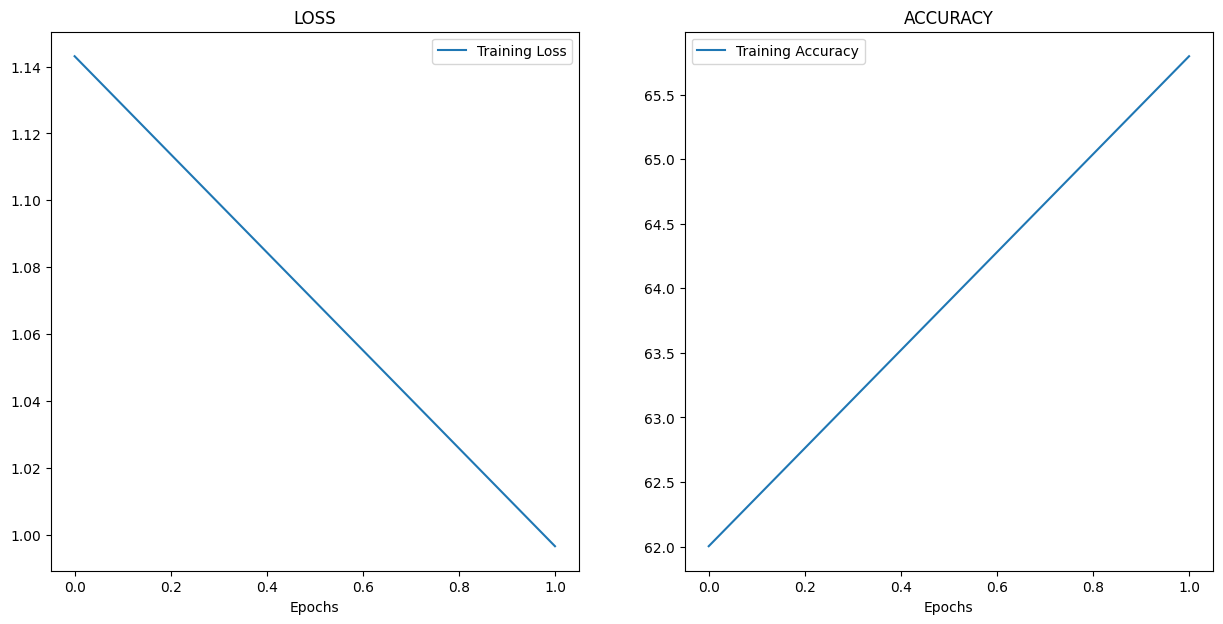

In [28]:
plot_curves(results)

**MOBILENET MODEL**

In [ ]:
# get pretrained model weights
weights = torchvision.models.MobileNet_V2_Weights.DEFAULT

model = torchvision.models.mobilenet_v2(weights=weights).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 122MB/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# freeze the convolutional layers of the model
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
# update the classifier of the model
# the output size of the layer should be same as the number of classes in the data
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(1280,len(train_data.classes))
).to(device)

print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
epochs = 5

# results dictionary
results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
}

In [ ]:
for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)

    # print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}%")
    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}%")

    # update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    # results["test_loss"].append(test_loss)
    # results["test_acc"].append(test_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4172 | train_acc: 57.29%
Epoch: 2 | train_loss: 1.4473 | train_acc: 59.11%
Epoch: 3 | train_loss: 1.4507 | train_acc: 59.15%
Epoch: 4 | train_loss: 1.4796 | train_acc: 59.27%
Epoch: 5 | train_loss: 1.4807 | train_acc: 58.94%


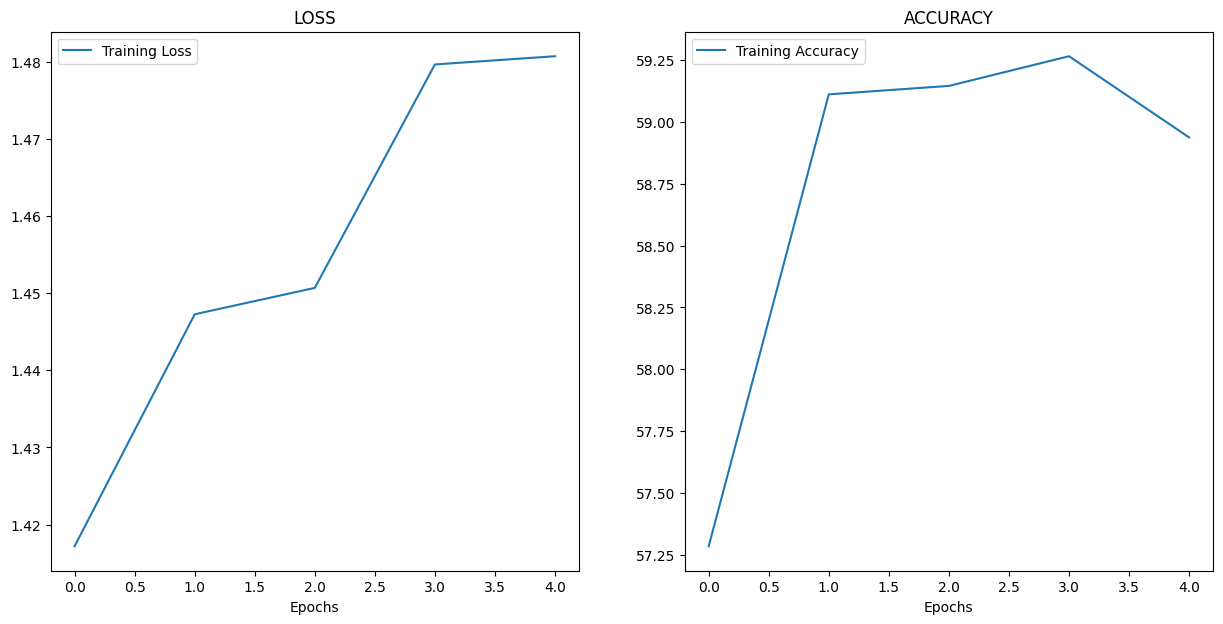

In [ ]:
plot_curves(results)

In [35]:
# get pretrained model weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT

model = torchvision.models.vit_b_16(weights=weights).to(device)
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [36]:
# freeze the convolutional layers of the model
for param in model.encoder.parameters():
    param.requires_grad = False

In [37]:
# update the classifier of the model
# the output size of the layer should be same as the number of classes in the data
model.heads = nn.Sequential(
    nn.Linear(768,len(train_data.classes))
).to(device)

print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [38]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)

In [39]:
epochs = 4

# results dictionary
results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
}

In [40]:
for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)

    # print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}%")
    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}%")

    # update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    # results["test_loss"].append(test_loss)
    # results["test_acc"].append(test_acc)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8952 | train_acc: 69.94%
Epoch: 2 | train_loss: 0.6158 | train_acc: 79.22%


KeyboardInterrupt: 

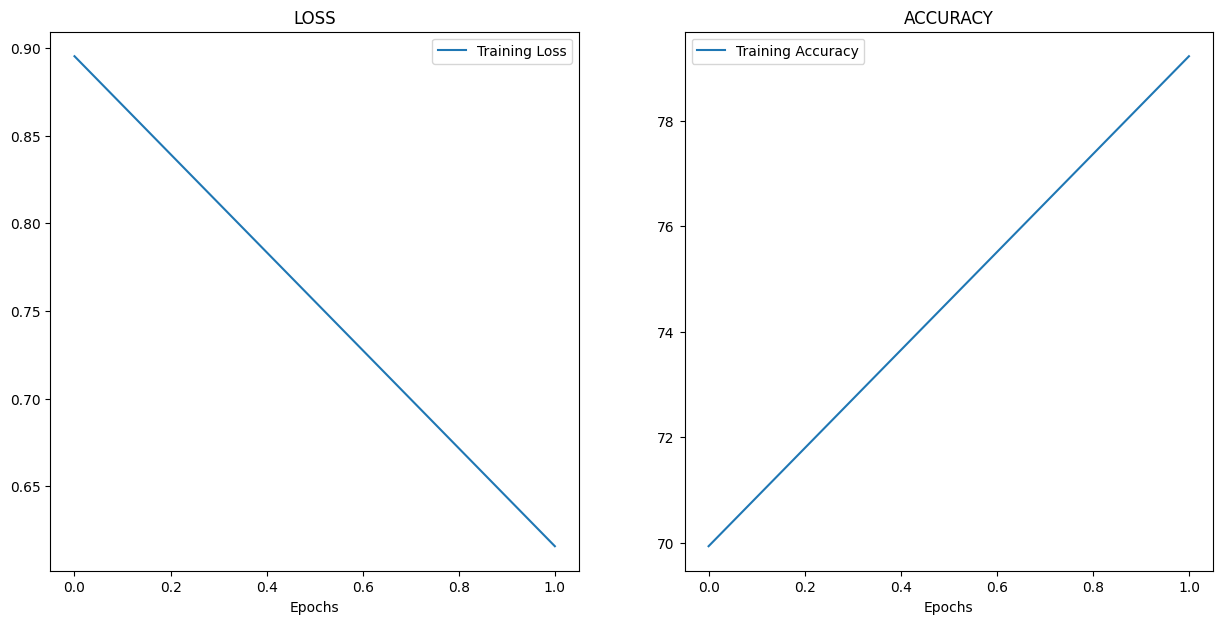

In [41]:
plot_curves(results)